In [1]:
setwd('/nfs/lab/projects/islet_cytok/analysis/snATAC/')

In [275]:
library(stringr)
library(ggplot2)
suppressPackageStartupMessages(library(enrichR))
dbs <- listEnrichrDbs()
dbs_sel =  "GO_Biological_Process_2021"

In [206]:
dbs$libraryName[grep ("eactome", dbs$libraryName)]

[1] "Reactome_2013" "Reactome_2015" "Reactome_2016"

In [2]:
nms =read.table("clusters_rank_genes_names.txt", header=T)

In [14]:
geneinfo = read.table('/nfs/lab/publicdata/gencode_v19/gene_info.tsv', header=T)

In [212]:
table(geneinfo$gene_type)


3prime_overlapping_ncrna                antisense                IG_C_gene 
                      21                     5276                       14 
         IG_C_pseudogene                IG_D_gene                IG_J_gene 
                       9                       37                       18 
         IG_J_pseudogene                IG_V_gene          IG_V_pseudogene 
                       3                      138                      187 
                 lincRNA                    miRNA                 misc_RNA 
                    7114                     3055                     2034 
                 Mt_rRNA                  Mt_tRNA   polymorphic_pseudogene 
                       2                       22                       45 
    processed_transcript           protein_coding               pseudogene 
                     515                    20345                    13931 
                    rRNA           sense_intronic        sense_overlapping 
           

In [61]:
geneinfo$TSS =  apply(geneinfo[,c('start','end', "strand")], 1, function(x) x[(x[3]=="-")+1 ])

   Length     Class      Mode 
    57820 character character 

In [62]:
geneinfo$TSS = as.numeric(geneinfo$TSS)

In [214]:
geneinfo = subset(geneinfo, gene_type=='protein_coding')

In [216]:
bed = cbind(geneinfo$chrom, as.numeric(geneinfo$TSS), as.numeric(geneinfo$TSS)+1, geneinfo$gene_name)

In [217]:
sum(duplicated(bed[,1:3]))

[1] 57

In [218]:
bed = bed[!duplicated(bed[,1:3]),]

In [39]:
#bed = bed[order(bed[,1], bed[,2]),]

In [43]:
#bed[,1]=gsub("chr",'',bed[,1])

In [219]:
write.table(bed, "gencode_v19.TSS.genenames_proteincoding.bed", sep="\t", quote=F, col.names=F, row.names=F)

In [79]:
peaks = cbind(str_split_fixed(nms$X1, ":|-",3), nms$X1)

In [80]:
peaks = peaks[order(peaks[,1]),]

In [85]:
peaks[grepl("CFTR",peaks[,1] ),]

[1] "CFTR" ""     ""     "CFTR"

In [95]:
peaks = subset(peaks, peaks[,3]!="")
peaks = subset(peaks, peaks[,2]!="")

In [97]:
peaks[,1]=paste0("chr",peaks[,1] )

In [98]:
write.table(peaks, "snATAC_peaks.bed", sep="\t", quote=F, col.names=F, row.names=F)

In [220]:
## run bedtools closest

In [241]:
promfile = read.table('snATAC_peaks.closestTSS.protCoding.bed')
promfile$V8[promfile$V9>50000]<-NA
promfile = subset(promfile, !duplicated(V4))

In [244]:
dim(promfile)

[1] 206792      9

In [245]:
dict = setNames(object = promfile$V8, nm = promfile$V4)

In [246]:
extra = nms$X1[!(nms$X1 %in% names(dict))]

In [247]:
dict = c(dict, setNames(extra,extra))

In [279]:
### Analyze different clusters

In [308]:
nms =read.table("clusters_rank_genes_names.txt", header=T)

genetab = apply(nms,2,function(x) dict[x])

lfc  = read.table("clusters_rank_genes_logfoldchanges.txt", header=T)
pv   = read.table("clusters_rank_genes_pvals.txt", header=T)
padj = read.table("clusters_rank_genes_pvals_adj.txt", header=T)
betaclus = c('X2','X3','X5','X0')

In [251]:
write.table(genetab, "clusters_rank_genes_genes_proteincoding.txt")

In [280]:
nms =read.table("clusters_rank_genes_names_beta.txt", header=T)

genetab = apply(nms,2,function(x) dict[x])

lfc  = read.table("clusters_rank_genes_logfoldchanges_beta.txt", header=T)
pv   = read.table("clusters_rank_genes_pvals_beta.txt", header=T)
padj = read.table("clusters_rank_genes_pvals_adj_beta.txt", header=T)


In [474]:
nms =read.table("clusters_rank_genes_names_alpha.txt", header=T)

genetab = apply(nms,2,function(x) dict[x])

lfc  = read.table("clusters_rank_genes_logfoldchanges_alpha.txt", header=T)
pv   = read.table("clusters_rank_genes_pvals_alpha.txt", header=T)
padj = read.table("clusters_rank_genes_pvals_adj_alpha.txt", header=T)


In [475]:
betaclus = c('X0','X1')

In [309]:
betaclus = c('X1','X7')

In [477]:
head(padj[,])

,X0,X1
,<dbl>,<dbl>
0,1.197900e-12,0.05457962
1,2.444092e-10,0.05858150
2,4.993998e-10,0.07620285
3,6.799338e-10,0.16999201
4,4.106089e-09,0.22049338
5,1.511797e-08,0.22770510


In [478]:
geneLists=list()
for (cl in betaclus){
   geneLists[[cl]]<-  na.omit(unique(genetab[,cl][lfc[,cl]>0.5 & padj[,cl]<0.05 ]  ))
  #  writeLines(geneLists[[cl]], paste0("clust.",cl, ".genelist.txt"))
}

In [479]:
grep ('GCG', geneLists$X1)

integer(0)

In [480]:
enriched = lapply(geneLists, function (x) enrichr(c(x), dbs_sel)) 

Uploading data to Enrichr... Done.
  Querying GO_Biological_Process_2021... Done.
Parsing results... Done.


No genes have been given



In [482]:
cnm = gsub('GO_Biological_Process_2021.', '', colnames(as.data.frame(enriched[[1]])[1:20,]))
#cnm = gsub('HDSigDB_Human_2021.', '', colnames(as.data.frame(enriched[[1]])[1:20,]))
plotlist = list()
for(ct in names(enriched)[[1]]){
df =  as.data.frame(enriched[ct])[1:20,]
colnames(df) = cnm
plotlist[[ct]] <- plotEnrich(df, showTerms = 20, numChar = 50, y = "Odds.Ratio",xlab = '', title = gsub("X", 'clus.',ct),
               orderBy = "P.value")+ scale_fill_gradient(  low = "gray30", high = "gray")+ theme(legend.key.size = unit(1, 'cm'), #change legend key size
        legend.key.height = unit(0.2, 'cm'), #change legend key height
        legend.key.width = unit(0.3, 'cm'), #change legend key width
        legend.title = element_text(size=8), #change legend title font size
        legend.text = element_text(size=5))
    
    }

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



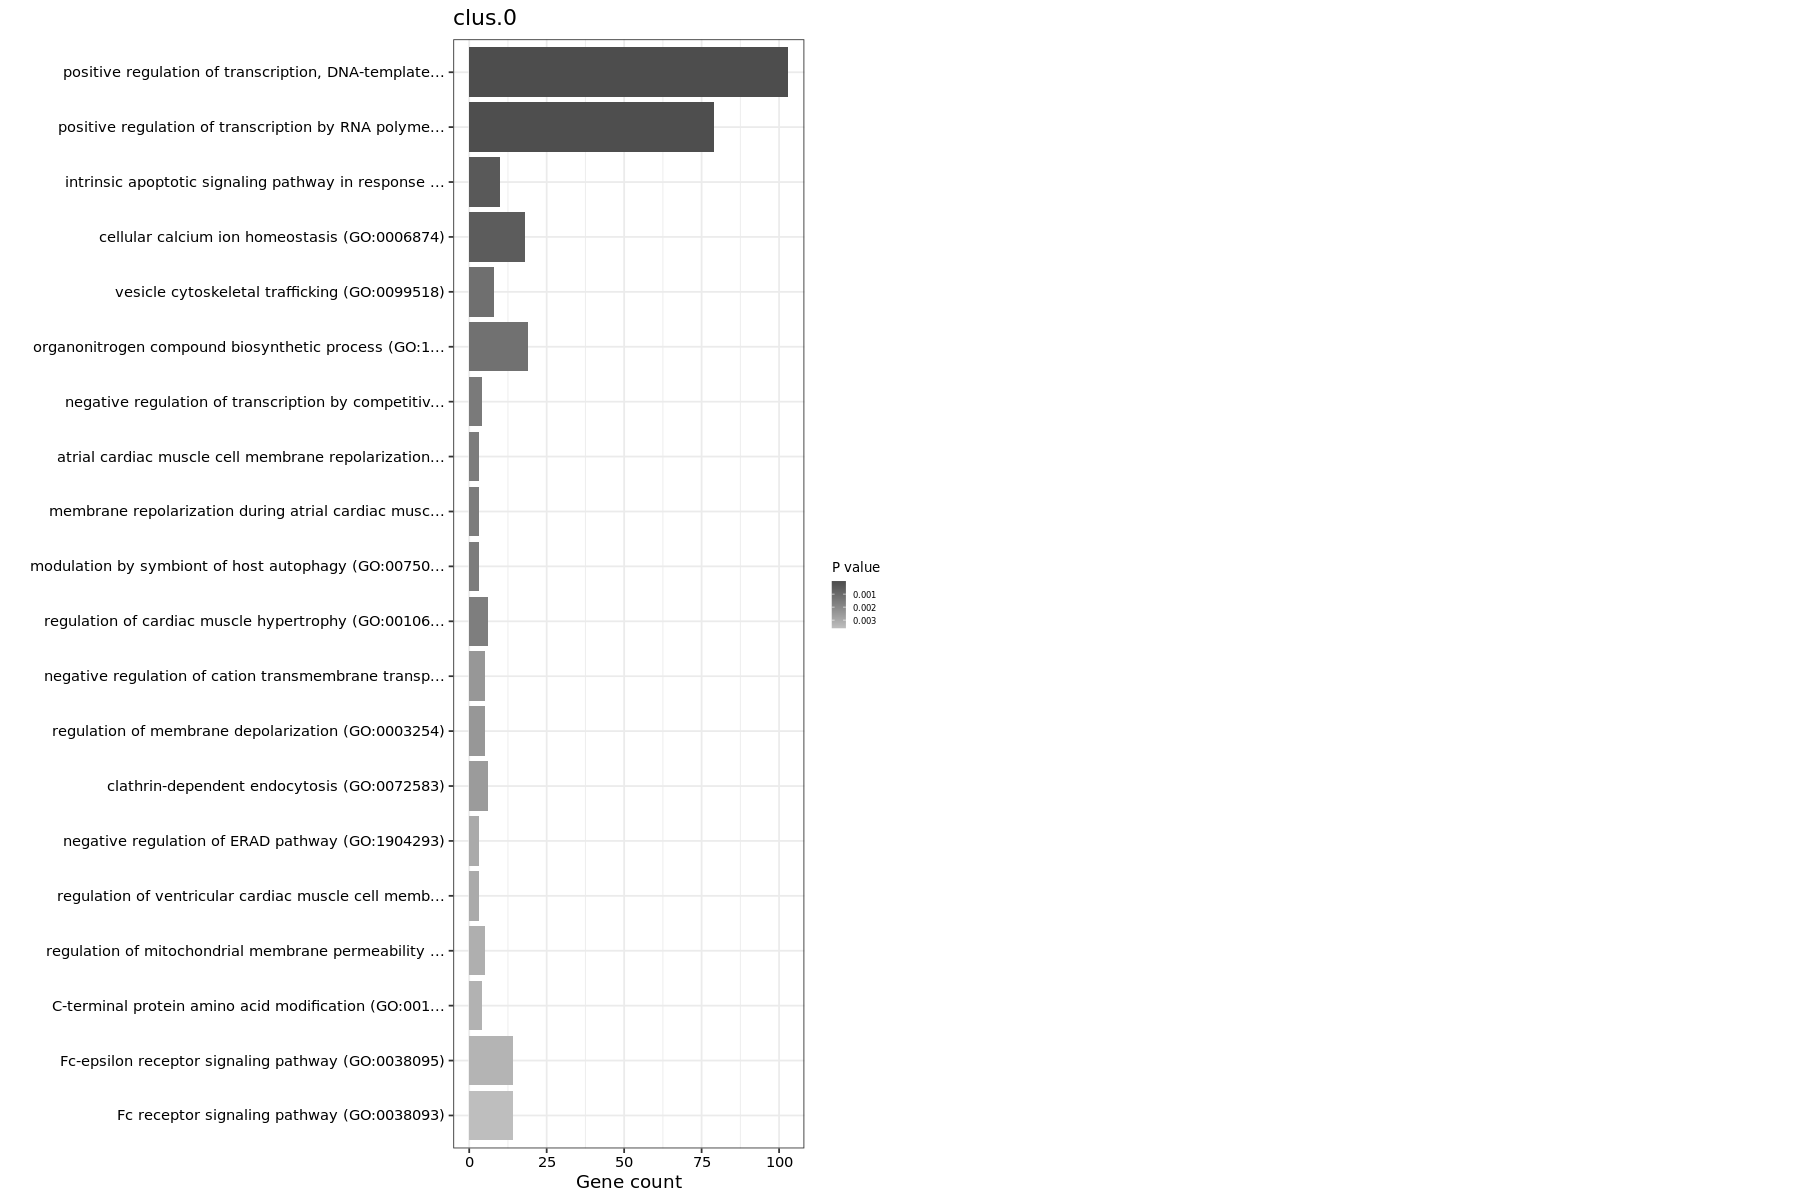

In [484]:
options(repr.plot.width=15, repr.plot.height=10)
ggsave( "GO_alpha01.pdf", gridExtra::grid.arrange( plotlist[[1]],
                        ncol=2),width=15, height=5)



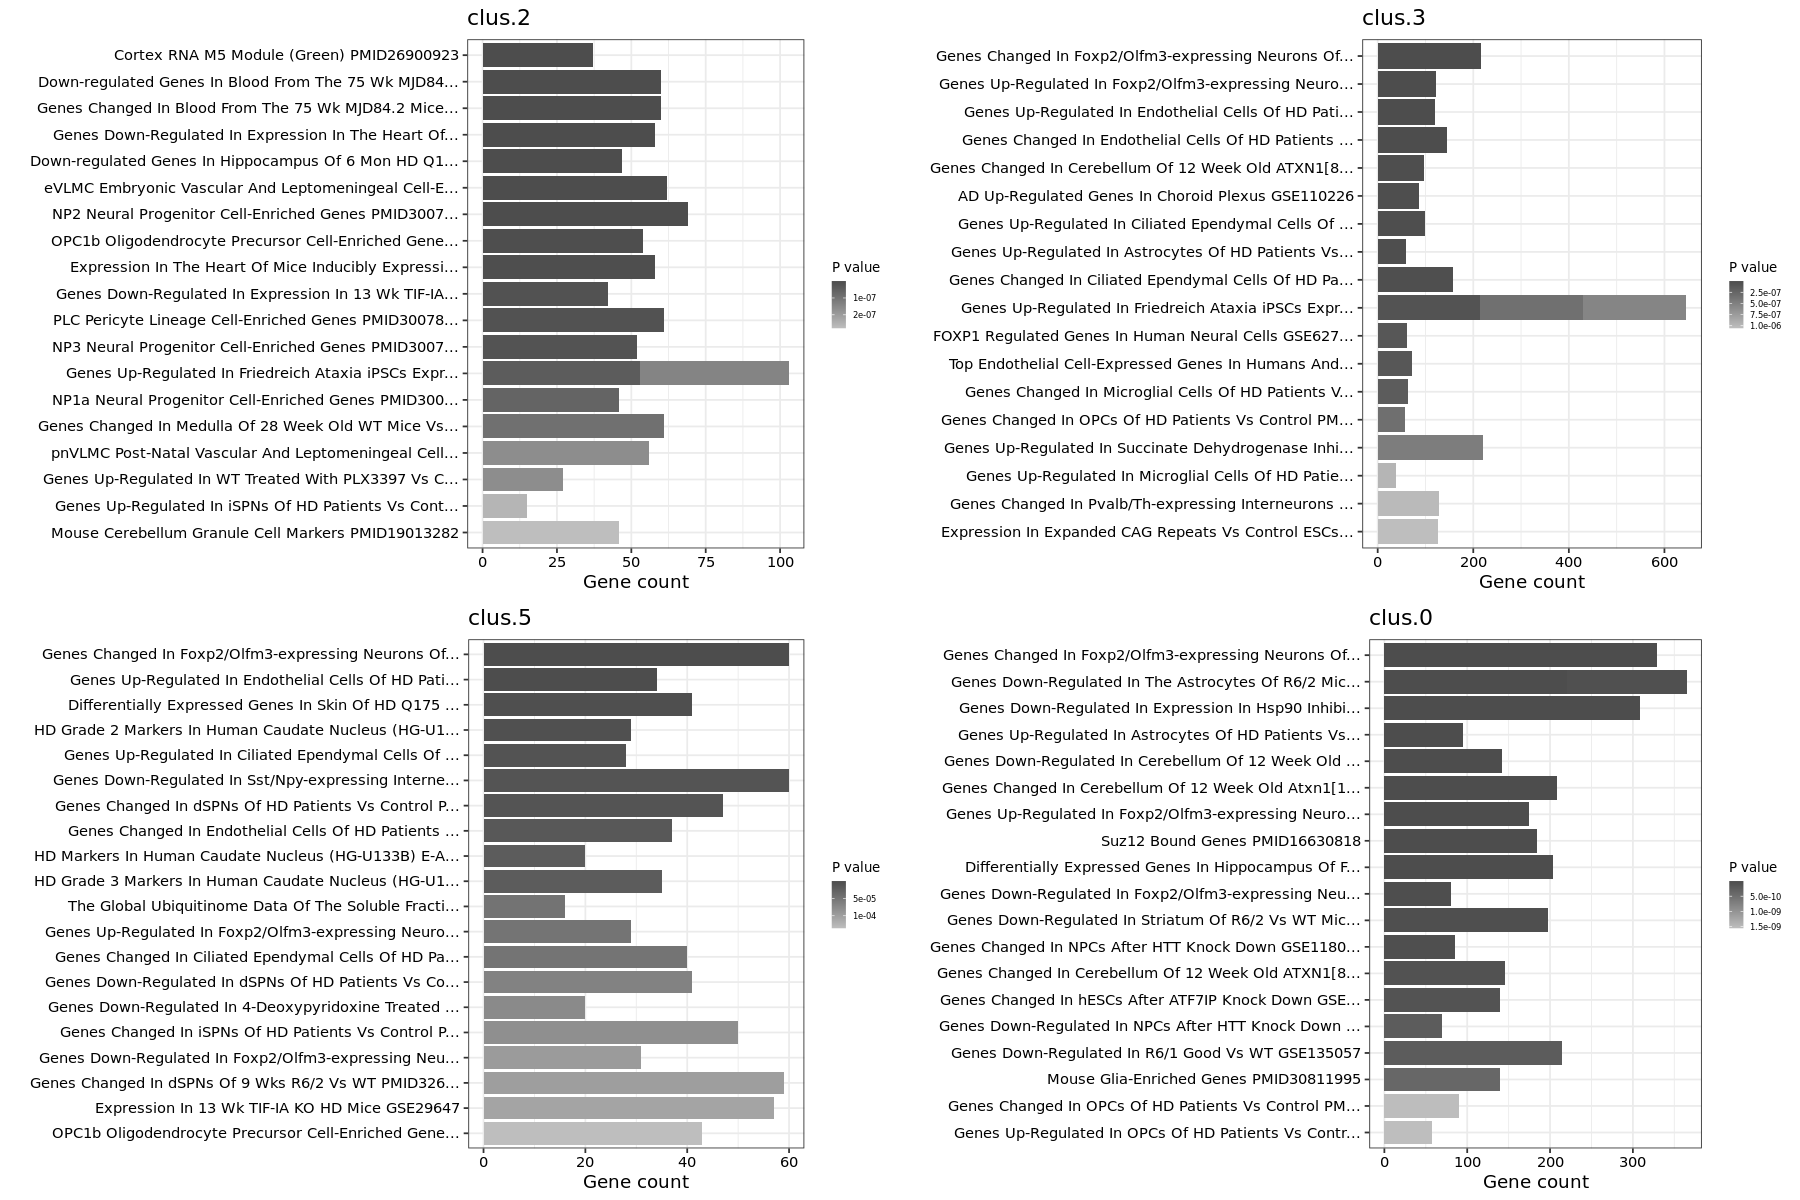

In [274]:
options(repr.plot.width=15, repr.plot.height=10)
ggsave( "HDSigDB_Human_2021.pdf", gridExtra::grid.arrange( plotlist[[1]],plotlist[[2]],plotlist[[3]],plotlist[[4]],
                        ncol=2),width=15, height=10)



In [258]:
geneLists[["X0"]][grep ("INS", geneLists[["X0"]])]

[1] "INS-IGF2" "INSRR"    "GINS4"    "GINS2"    "INS"

### Remake ClusteringFigure

In [337]:
bcs = read.table('barcode_and_cluster_demux.tsv', header=T, row.names=1)

In [375]:
beta = cbind(read.table('newclusters_only_proj_donor_beta.txt', header=T),
       read.table('newclusters_only_proj_donor_beta_UMAP.txt', header=T))

In [378]:
alpha = cbind(read.table('newclusters_only_proj_donor_alpha.txt', header=T),
       read.table('newclusters_only_proj_donor_alpha_UMAP.txt', header=T))

In [379]:
beta$leidenb = paste0(beta$leiden, "b")
alpha$leidenb = paste0(alpha$leiden, "a")

In [329]:
news = rbind(beta,alpha )

In [338]:
bcs$new_leidens = bcs$leiden

In [343]:
bcs$new_leidens [match(rownames(news),bcs$X)]<- news$leidenb

In [345]:
table(bcs$new_leidens)


  0a   0b   1a   1b    4    6    8    9 
1731 2934  382 1333  541  327  362  219 

In [364]:
cols = c('0b' = '#FDBF6F','1b' = '#FF7F00','0a' = '#1F78B4','1a' = '#A6CEE3','4' = '#E7298A',
          '6' = '#33A02C','8' = '#CAB2D6','9' = '#666666')

In [488]:
cols2 = c('0b' = '#FDBF6F','1b' = '#FF7F00','0a' = '#1F78B4','1a' = '#1F78B4','4' = '#E7298A',
          '6' = '#33A02C','8' = '#CAB2D6','9' = '#666666')

In [360]:
nms = c('0b' = 'Beta_1','1b' = 'Beta_2','0a' = 'Alpha_1','1a' = 'Alpha_2','4' = 'Delta',
          '6' = 'Acinar','8' = 'Stellate','9' = 'Endothelial')

In [361]:
bcs$new_clust = nms[bcs$new_leiden]

In [362]:
ag  = aggregate(list(bcs$UMAP1, bcs$UMAP2) , 
                by = list(bcs$new_clust, bcs$new_clust) , mean   ) 

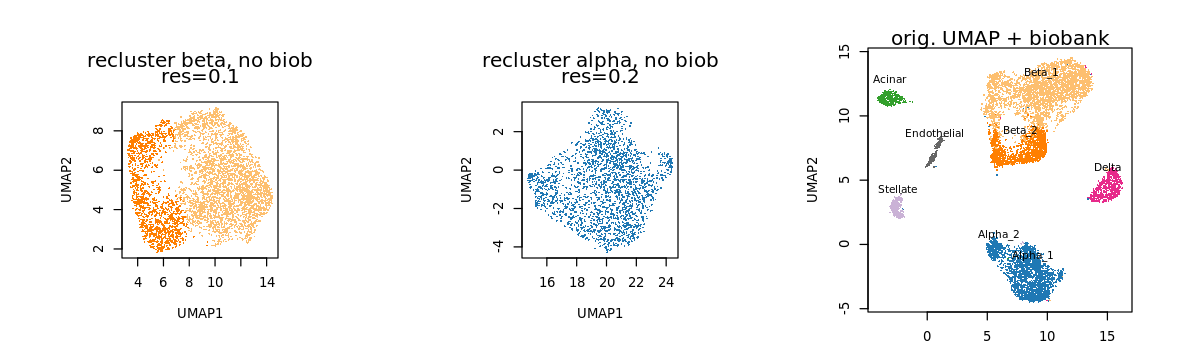

In [489]:
options(repr.plot.width=10, repr.plot.height=3)
par ( mfrow=c(1,3))
#par (pin = c(2.5, 2.5))
#par (mar = c(4, 4,4,4))
par (pin = c(1.3, 1.3))
plot(UMAP2~UMAP1, beta, pch = 16, cex=0.3, bty='o', col= cols[beta$leidenb])
mtext("recluster beta, no biob", line=2)
mtext("res=0.1", line=1)
plot(UMAP2~UMAP1, alpha, pch = 16, cex=0.3, bty='o', col= cols2[alpha$leidenb])
mtext("recluster alpha, no biob", line=2)
mtext("res=0.2", line=1)
par (pin = c(2.2, 2.2))
plot(UMAP2~UMAP1, bcs, pch = 16, cex=0.3, bty='o', col= cols2[bcs$new_leidens])
text (ag[,3], ag[,4], labels = ag[,1], cex=0.8, pos=3,offset = 1)
mtext("orig. UMAP + biobank")


In [491]:
getwd()

[1] "/nfs/lab/projects/islet_cytok/analysis/snATAC"

In [492]:
png("../cytokine_figures/UMAP_clusters_small_new.png", width = 2, height = 2, units = 'in', res = 300)
par (mar=c(0,0,0,0))
plot(UMAP2~UMAP1, bcs, pch = 16, cex=0.3, bty='n', col= cols2[bcs$new_leidens],axes=F)

dev.off()


png 
  2

In [411]:
library(RColorBrewer)

In [412]:
SampleC = data.frame(brewer.pal(9, "Paired")[c(2,7,6,4)], 
                     c('isl3535', "isl9245", 'isl7453', 'isl4807'))

In [455]:
SampleC = SampleC[order(SampleC[,2]),]

In [493]:
bcs$new_clust[bcs$new_clust=="Alpha_2"]<-"Alpha_1"

In [494]:
tb = table(bcs$donor, bcs$new_clust)
tb = tb[1:4,]
pct = t(t(tb)/colSums(tb))

In [495]:
tb2 = table(bcs$treat, bcs$new_clust)
pct2 = t(t(tb2)/colSums(tb2))

In [496]:
bcs$new_exp = paste0(bcs$donor, bcs$treat)

In [497]:
tb3 = table(bcs$new_exp, bcs$new_clust)[1:7,]
pct3 = t(t(tb3)/colSums(tb3))

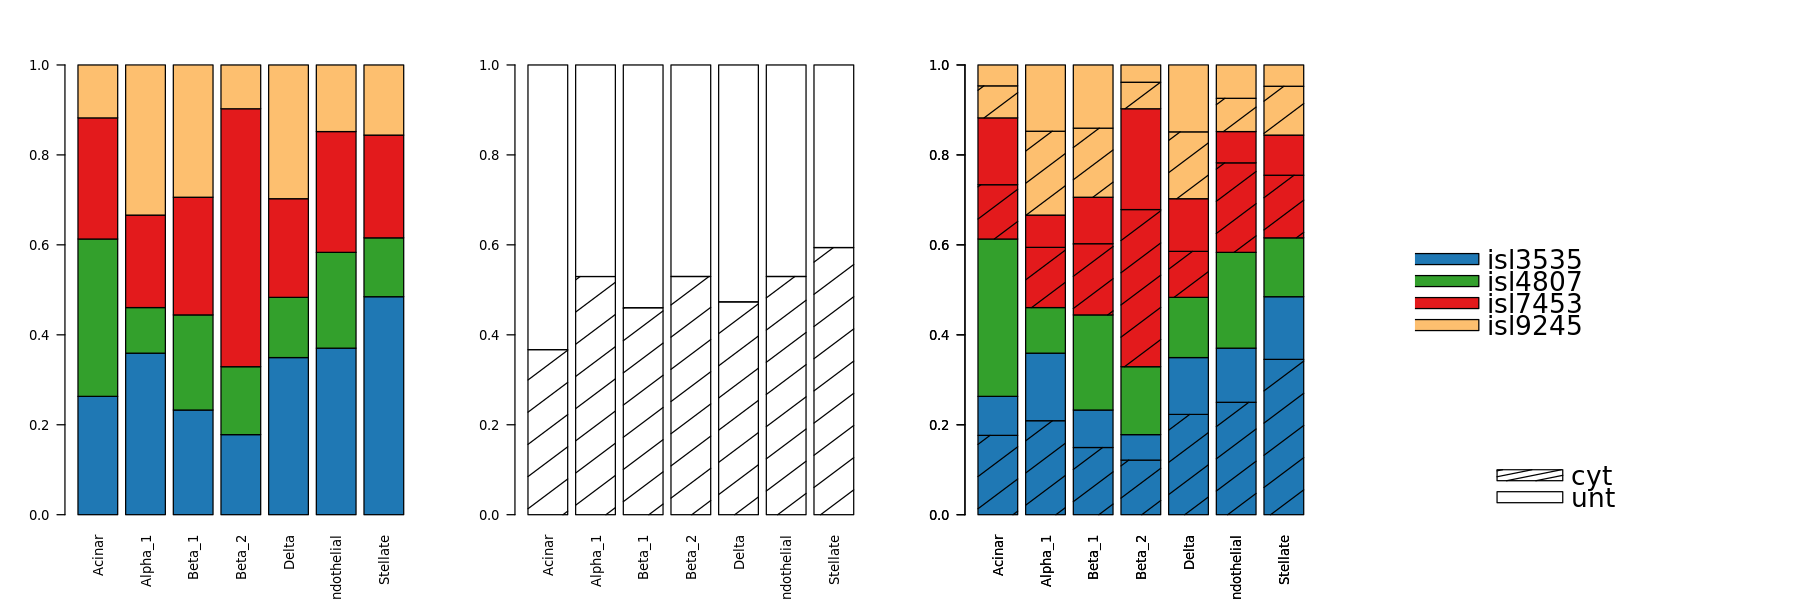

In [498]:
options(repr.plot.width=15, repr.plot.height=5)
par(mfrow=c(1,4), las=2)
barplot(pct, col=SampleC[,1])
barplot(pct2,density=c(10,0), col=1, angle = 75)
barplot(pct3, col = SampleC[c(1,1,2,3,3,4,4),1])
barplot(pct3,density=c(10,0,0,10,0,10,0), col=1, angle = 75, border=F, add=T)
plot.new()
legend("center",  fill = as.character(SampleC[,1]),bty="n",x.intersp = 0.1,
       legend= SampleC[,2], cex=2)
legend("bottomleft",density=c(20,0), legend=c('cyt', 'unt'),bty="n", ,x.intersp = 0.1,cex=2)


In [503]:
pdf("../cytokine_figures/UMAP_donors_barplot_new.pdf")
par(mfrow = c(2,2), xpd=T, las=2)
barplot(pct, col=SampleC[,1])
barplot(pct2,density=c(20,0), col=1, angle = 75)
barplot(pct3, col = SampleC[c(1,1,2,3,3,4,4),1])
barplot(pct3,density=c(20,0,0,20,0,20,0), col=1, angle = 75, border=F, add=T)
plot.new()
legend("center",  fill = as.character(SampleC[,1]),bty="n",x.intersp = 0.1,
       legend= SampleC[,2], cex=2)
legend("bottomleft",density=c(20,0), legend=c('cyt', 'unt'),bty="n", ,x.intersp = 0.1,cex=2)
dev.off()

png 
  2

In [506]:
### GEO table

In [507]:
bcs$new_clust[bcs$new_clust=="Alpha_1"]<-"Alpha"

In [532]:
bcs = bcs[, !(colnames(bcs) %in% c('bam','bc', "X", "cluster", 'subset', 'norm', 'treat2', 'new_leidens', 'samples'))]

In [542]:
bcs = bcs[,c(21,16,20,22,24,1,23,2,3, 4:15,18,19)]

In [546]:
colnames(bcs)[3:7] = c("treatment", "donor" , "experiment_after_deconvolution" , "clusters_with_extra_samples", "assigned_celltype")


In [550]:
write.csv(bcs, "../../geo_submission_oct21/processed_files/snATAC_barcodes_and_metadata.csv")